In [12]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

Configuration

In [13]:
# =========================
# PATHS & DATA SETTINGS
# =========================
DATA_DIR = r"C:\Users\joelj\CHALMERS\Exchange\Intelligent Systems\Individual Project\Data\SHM-Data"
FILENAME_PATTERN = "pc_f100kHz.h5"

BASELINE_IDS = range(1, 29)   # B1 ... B28
DAMAGE_IDS   = range(1, 29)   # D1 ... D28

# =========================
# SIGNAL PROCESSING
# =========================
FS = 1e6        # sampling frequency
NPERSEG = 256
NOVERLAP = 128

# =========================
# TRAINING
# =========================
BATCH_SIZE = 16
EPOCHS = 15
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Data handling and spectrogram conversion

In [14]:
def load_h5_file(filepath):
    with h5py.File(filepath, "r") as f:
        signals = f["pitchcatch/catch"][:]  # (66, signal_length)
    return signals

def compute_spectrogram(signal):
    f, t, Sxx = spectrogram(
        signal,
        fs=FS,
        # window="hann",
        nperseg=NPERSEG,
        noverlap=NOVERLAP,
        mode="magnitude"
    )
    return Sxx

def collect_data():
    X, y = [], []

    # -------- Baseline (healthy = 0) --------
    for bid in BASELINE_IDS:
        filename = f"B{bid}pc_f100kHz.h5"
        filepath = os.path.join(DATA_DIR, filename)
        signals = load_h5_file(filepath)
        for sig in signals:
            S = compute_spectrogram(sig)
            X.append(S)
            y.append(0)

    # -------- Damage (damaged = 1) --------
    for did in DAMAGE_IDS:
        filename = f"D{did}pc_f100kHz.h5"
        filepath = os.path.join(DATA_DIR, filename)
        signals = load_h5_file(filepath)
        for sig in signals:
            S = compute_spectrogram(sig)
            X.append(S)
            y.append(1)

    X = np.array(X)
    y = np.array(y)

    # Log + normalize
    X = np.log10(X + 1e-10)
    X = (X - X.mean(axis=(1,2), keepdims=True)) / (
        X.std(axis=(1,2), keepdims=True) + 1e-6
    )

    return X, y

class SHMSpectrogramDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    


Load data

In [15]:
# Load data
X, y = collect_data()
print("Data shape:", X.shape)
print("Healthy:", np.sum(y == 0))
print("Damaged:", np.sum(y == 1))

# Train, Val, Test split
# 1: (train + val) vs test
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
# 2: train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp,
    test_size=0.2,  # 0.2 × 0.8 = 16% validation
    stratify=y_tmp,
    random_state=42
)

# Class weights for weighted loss
classes = np.array([0, 1])
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y
)
class_weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE)
print("Class weights:", class_weights)

train_ds = SHMSpectrogramDataset(X_train, y_train)
val_ds   = SHMSpectrogramDataset(X_val, y_val)
test_ds  = SHMSpectrogramDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


Data shape: (3696, 129, 101)
Healthy: 1848
Damaged: 1848
Class weights: tensor([1., 1.])


Visualization

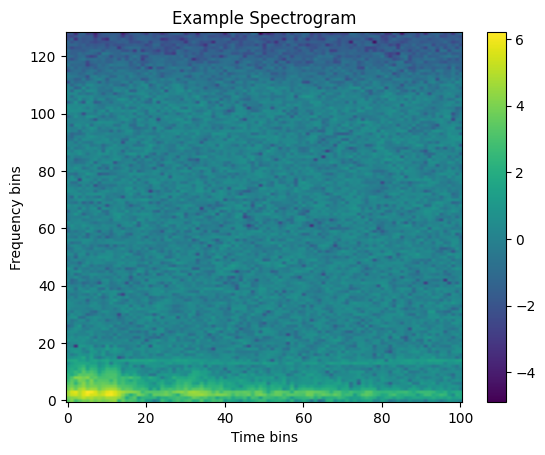

In [16]:
plt.imshow(X[0], aspect="auto", origin="lower")
plt.title("Example Spectrogram")
plt.xlabel("Time bins")
plt.ylabel("Frequency bins")
plt.colorbar()
plt.show()

CNN model

In [17]:
class CNN2D(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Infer fully connected size automatically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, *input_shape)
            n_features = self.conv(dummy).view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


Model, Loss & Optimizer

In [18]:
model = CNN2D(input_shape=X.shape[1:]).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Training

In [19]:
# Training loop
train_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- VALIDATION ----
    model.eval()
    val_acc = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1)

    val_acc = accuracy_score(yb, preds)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1:02d}/{EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch 01/15 | Train Loss: 0.7061 | Val Acc: 0.5000
Epoch 02/15 | Train Loss: 0.6919 | Val Acc: 0.5000
Epoch 03/15 | Train Loss: 0.6493 | Val Acc: 0.7500
Epoch 04/15 | Train Loss: 0.4553 | Val Acc: 0.5000
Epoch 05/15 | Train Loss: 0.1765 | Val Acc: 0.5625
Epoch 06/15 | Train Loss: 0.0543 | Val Acc: 0.3750
Epoch 07/15 | Train Loss: 0.0196 | Val Acc: 0.5000
Epoch 08/15 | Train Loss: 0.0044 | Val Acc: 0.5625
Epoch 09/15 | Train Loss: 0.0013 | Val Acc: 0.5625
Epoch 10/15 | Train Loss: 0.0007 | Val Acc: 0.5625
Epoch 11/15 | Train Loss: 0.0005 | Val Acc: 0.5625
Epoch 12/15 | Train Loss: 0.0004 | Val Acc: 0.5625
Epoch 13/15 | Train Loss: 0.0003 | Val Acc: 0.5625
Epoch 14/15 | Train Loss: 0.0002 | Val Acc: 0.5625
Epoch 15/15 | Train Loss: 0.0002 | Val Acc: 0.5625


Train loss vs Validation accuracy

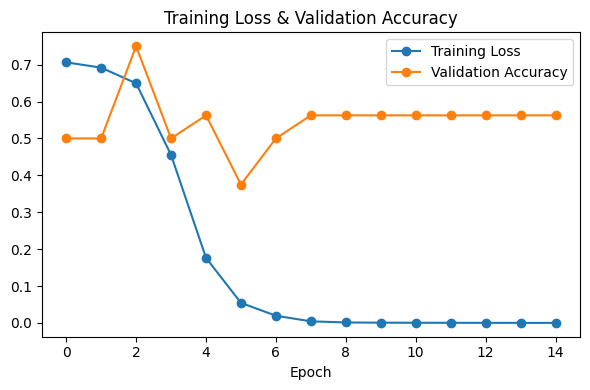

In [20]:
plt.figure(figsize=(6, 4))

# plt.subplot(1, 2, 1)
plt.plot(train_losses, marker="o", label="Training Loss")
plt.plot(val_accuracies, marker="o", label="Validation Accuracy")
plt.title("Training Loss & Validation Accuracy")
plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


Evaluation

In [21]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        out = model(xb)
        preds = torch.argmax(out, dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(yb.numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(
    y_true, y_pred,
    target_names=["Healthy", "Damaged"]
))

Test Accuracy: 0.5108
              precision    recall  f1-score   support

     Healthy       0.51      0.55      0.53       370
     Damaged       0.51      0.48      0.49       370

    accuracy                           0.51       740
   macro avg       0.51      0.51      0.51       740
weighted avg       0.51      0.51      0.51       740



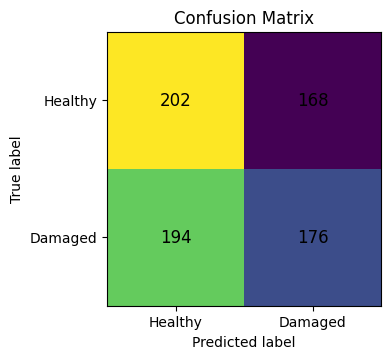

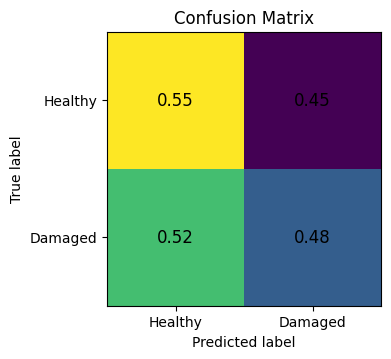

In [22]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.xticks(range(len(class_names)), class_names)
    plt.yticks(range(len(class_names)), class_names)

    # Print numbers in each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, cm[i, j],
                ha="center", va="center",
                fontsize=12
            )

    # plt.colorbar()
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(
    cm,
    class_names=["Healthy", "Damaged"]
)

cm_norm = np.round(cm.astype(float) / cm.sum(axis=1, keepdims=True),decimals=2)
plot_confusion_matrix(
    cm_norm,
    class_names=["Healthy", "Damaged"]
)